# Overview
* Objective: This project focuses on building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

* Our approach: We will be employing Convolutional Neural Networks (CNNs), a powerful class of deep learning models tailored for visual image analysis. CNNs excel in detecting patterns and features within images, making them well-suited for identifying subtle variations in tissue samples indicative of cancerous cells. We will be predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0. we will evaluate our model based on F1 score.

* Dataset: We’ll use a dataset of 7613 tweets where each sample in the train and test set has the following information:
  * The text of a tweet
  * A keyword from that tweet (although this may be blank!)
  * The location the tweet was sent from (may also be blank)

  Columns
  * id - a unique identifier for each tweet
  * text - the text of the tweet
  * location - the location the tweet was sent from (may be blank)
  * keyword - a particular keyword from the tweet (may be blank)
  * target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started


## Note: Please run this notebook in Google Colab.

#Data Overview
#### 1. Load data from Kaggle

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import re
import spacy
from gensim.models import Word2Vec
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir -p ~/.kaggle
! cp -rf /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! rm -rf /content/nlp-getting-started
! mkdir -p /content/nlp-getting-started

In [ ]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 138MB/s]


In [ ]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile("/content/nlp-getting-started.zip", "r") as zip_ref:
   zip_ref.extractall("/content/nlp-getting-started")

# Delete the zip file
os.remove("/content/nlp-getting-started.zip")

In [ ]:
test_path = '/content/nlp-getting-started/test.csv'
train_path = '/content/nlp-getting-started/train.csv'
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

#### 2. Data Inspection

In [ ]:
train_df.info()
print("")
print(train_df.head())
print("")
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

                 id      target
count  

In [ ]:
test_df.info()
print("")
print(test_df.head())
print("")
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    1

In [ ]:
print('Training Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))


Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


We can see that the dataset contains 7613 trining samples and 3263 test samples, each representing a tweet.
Train labels file has 5 columns and test has 4 columns :
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real * disaster (1) or not (0).

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

#### 1. Inspect null values

In [ ]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

print("Null values in training dataset:")
for c in train_df.columns:
    string_null = np.array([x in a[2:] for x in train_df[c]])
    print(c, train_df[c].isnull().sum(), string_null.sum())

print("")
print("Null values in test dataset:")
for c in test_df.columns:
    string_null = np.array([x in a[2:] for x in test_df[c]])
    print(c, test_df[c].isnull().sum(), string_null.sum())

Null values in training dataset:
id 0 0
keyword 61 0
location 2533 4
text 0 0
target 0 0

Null values in test dataset:
id 0 0
keyword 26 0
location 1105 1
text 0 0


We can see that:
 - the 'keyword' column has 61 null values in train and 26 null values in test dataset.
 - the 'location' column has 2533 null values, 4 string nulls in train and 1105 null values, 1 string null in test

Let's find out what are the string-typed null/none values in 'location'

In [ ]:
for x in train_df['location']:
    if x in a[2:]:
        print(x, a.index(x))

? 9
? 9
? 9
? 9


We can see that we have space '?' question mark in location.
We will them replace them with null later.

Let's find out percentage of missing values by columns

In [ ]:
# Calculating the Missing Values % contribution in train_df and test_df

train_df_null = round(100*(train_df.isnull().sum())/len(train_df), 2)
train_df_null

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

We will drop rows with missing values in keyword column since missing values are a small percentage.
For location we since 33% values are missing we will drop the whole column.

#### 2. Visualize Class Distribution:

Let's create a bar chart to visualize the distribution of the 'target' column to check for potential class imbalance.
We will use a pie chart to provide a more intuitive representation of the class proportions.

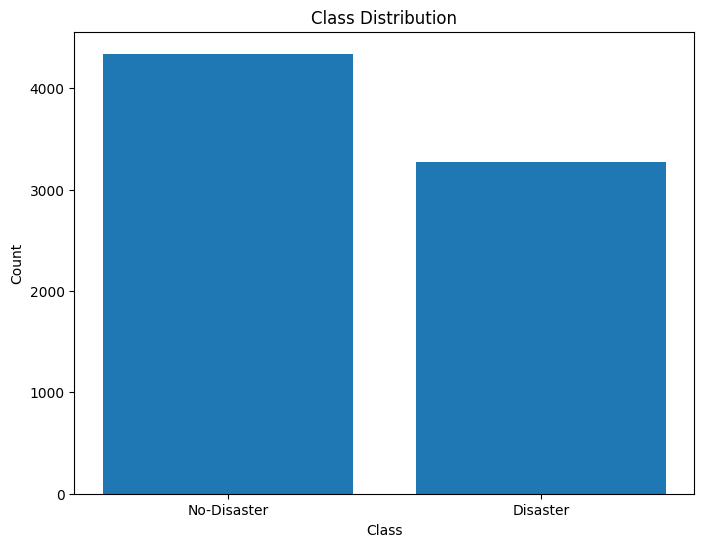

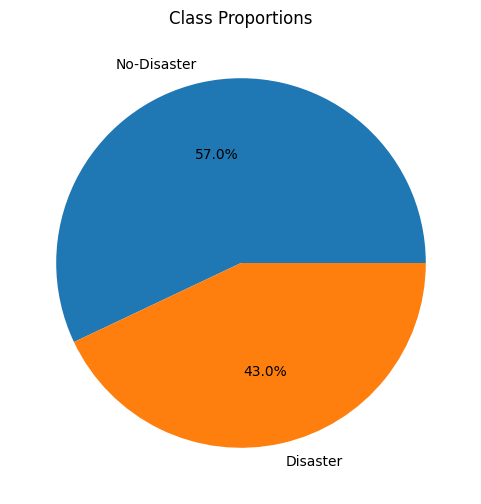

In [ ]:
# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(['No-Disaster', 'Disaster'], train_df['target'].value_counts())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print("")
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(train_df['target'].value_counts(), labels=['No-Disaster', 'Disaster'], autopct="%1.1f%%")
plt.title('Class Proportions')
plt.show()

In [ ]:
# Get the number of tweets for each target value
target_counts = train_df["target"].value_counts()
print(target_counts)

0    4342
1    3271
Name: target, dtype: int64


 We can see that about 43% of the tweets are for real disaster, which indicates a fairly balanced dataset but with a slight imbalance towards non-disaster samples. However, the imbalance is not very large so we will go ahead with the complete dataset without having to resample.

#### 2. Visualize Class Examples:

Let's see some examples for each class - No-Disaster(0) and Disaster(1)

In [ ]:
# Print examples of tweets for each class
print("Examples of No-Disaster (0) tweets:")
print(train_df[train_df["target"] == 0].head())

print("\nExamples of Disaster (1) tweets:")
print(train_df[train_df["target"] == 1].head())

Examples of No-Disaster (0) tweets:
    id keyword location                          text  target
15  23     NaN      NaN                What's up man?       0
16  24     NaN      NaN                 I love fruits       0
17  25     NaN      NaN              Summer is lovely       0
18  26     NaN      NaN             My car is so fast       0
19  28     NaN      NaN  What a goooooooaaaaaal!!!!!!       0

Examples of Disaster (1) tweets:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


#### 3. Visualize distribution of the text lengths

Let's plot the distribution of the text lengths

<Axes: ylabel='Frequency'>

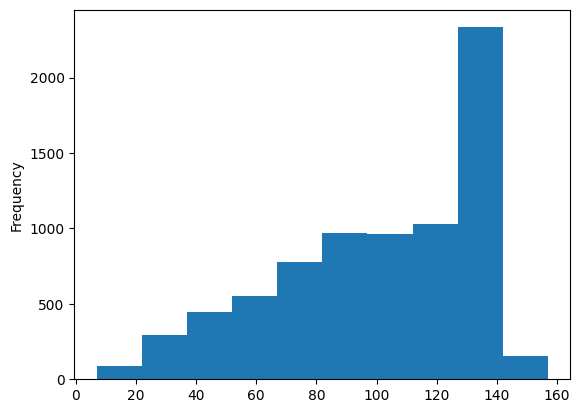

In [ ]:
# Plot the distribution of the text lengths
train_df["text_length"] = train_df["text"].str.len()
train_df["text_length"].plot.hist()

We can see that most of the text have 100-140 character lengths.

# Data Processing and Cleaning

####1. Dropping rows and columns
* As mentioned before, we will drop rows with missing keyword value.
* And we will drop location column due to 33% missing values in it.

In [ ]:
# Drop rows with missing keyword values
train_df = train_df.dropna(subset=["keyword"])

# Drop the location column
train_df = train_df.drop("location", axis=1)
train_df = train_df.reset_index(drop=True)

test_df = test_df.drop("location", axis=1)
test_df = test_df.reset_index(drop=True)

In [ ]:
# Print the shape of the DataFrame to confirm changes
print(train_df.shape)
print(train_df.info())
print("")
print(test_df.shape)
print(test_df.info())

(7552, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7552 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7552 non-null   object
 3   target   7552 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 236.1+ KB
None

(3263, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3263 non-null   int64 
 1   keyword  3237 non-null   object
 2   text     3263 non-null   object
dtypes: int64(1), object(2)
memory usage: 76.6+ KB
None


In [ ]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

print("Null values in training dataset:")
for c in train_df.columns:
    string_null = np.array([x in a[2:] for x in train_df[c]])
    print(c, train_df[c].isnull().sum(), string_null.sum())

print("")
print("Null values in test dataset:")
for c in test_df.columns:
    string_null = np.array([x in a[2:] for x in test_df[c]])
    print(c, test_df[c].isnull().sum(), string_null.sum())

Null values in training dataset:
id 0 0
keyword 0 0
text 0 0
target 0 0

Null values in test dataset:
id 0 0
keyword 26 0
text 0 0


Now we don't have any kind of null values in our dataset.

#### 2. Preprocess the text
* Remove punctuations
* convert all to lower-case
* Lemmatize words, we will use spaCy as it often provides the most accurate lemmatization, especially for context-sensitive cases.

In [ ]:
#Before preprocessing
train_df.head()

,id,keyword,text,target
0,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,52,ablaze,Crying out for more! Set me ablaze,0
4,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
def preprocess_text(text):
    text = text.lower()  # Lowercase

    # Remove most punctuation, but keep some specific characters
    text = re.sub(r"[^\w\s\-!?.,:/;]", "", text)

    # Lemmatize words using spaCy
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])

    return lemmatized_text

# Apply preprocessing
train_df["text"] = train_df["text"].apply(preprocess_text)

In [ ]:
test_df["text"] = test_df["text"].apply(preprocess_text)

In [ ]:
#After preprocessing
train_df.head()

,id,keyword,text,target
0,48,ablaze,bbcmtd wholesale market ablaze http://t.co/lhy...,1
1,49,ablaze,we always try to bring the heavy . metal rt ht...,0
2,50,ablaze,africanbaze : break news : nigeria flag set ab...,1
3,52,ablaze,cry out for more ! set I ablaze,0
4,53,ablaze,on plus side look at the sky last night it be ...,0


#### 3. Tokenize the text
We will be converting text data into numerical sequences that machine learning models can understand. This is crucial because models can't directly process raw text.

Steps involved:

* Learning the vocabulary: The tokenizer identifies unique words in the training text.
* Assigning word indices: Each word is assigned a unique numerical index.
* Transforming text into sequences: Each text sample is represented as a list of word indices based on the vocabulary.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["text"])
vocab_size = len(tokenizer.word_index) + 1
train_sequences = tokenizer.texts_to_sequences(train_df["text"])
test_sequences = tokenizer.texts_to_sequences(test_df["text"])

In [ ]:
#Let's see the preprocessed text vs tokenised sequences
for text, sequence in zip(train_df["text"].tolist()[:5], train_sequences[:5]):
    print("Preprocessed text:", text)
    print("Sequence:", sequence)

Preprocessed text: bbcmtd wholesale market ablaze http://t.co/lhyxeohy6c
Sequence: [5873, 2617, 424, 625, 3, 1, 2, 5874]
Preprocessed text: we always try to bring the heavy . metal rt http://t.co/yao1e0xngw
Sequence: [32, 351, 238, 8, 425, 4, 864, 1160, 122, 3, 1, 2, 5875]
Preprocessed text: africanbaze : break news : nigeria flag set ablaze in aba . http://t.co/2nndbgwyei
Sequence: [5876, 214, 64, 2224, 691, 245, 625, 9, 1103, 3, 1, 2, 5877]
Preprocessed text: cry out for more ! set I ablaze
Sequence: [829, 45, 13, 59, 245, 7, 625]
Preprocessed text: on plus side look at the sky last night it be ablaze http://t.co/qqsmshaj3n
Sequence: [14, 1607, 714, 84, 22, 4, 902, 159, 299, 20, 5, 625, 3, 1, 2, 5878]


#### 4. Create embedding matrix


We will use Word2Vec for creating embedding matrix.
An embedding matrix is a numerical representation of words where each word is represented by a dense vector of real numbers, capturing its meaning and relationships with other words.

Word2Vec is a technique that maps words from a vocabulary to numerical vectors, capturing their semantic relationships and meanings. It's like creating a map of word associations, where words that often appear together in similar contexts are placed closer together in this vector space.

How it works:

Learning from context: Word2Vec analyzes large amounts of text, observing how words co-occur within a specified window of surrounding words. It learns patterns of how words are used together.

Two main approaches:

* Skip-gram: Predicts surrounding words (context) given a target word.
CBOW (Continuous Bag-of-Words): Predicts the target word given its surrounding context words.
* Vector representations: Through this training process, each word is assigned a unique vector (a list of numbers) that encodes its meaning and relationships with other words.

Key benefits:

* Captures semantic similarity: Words with similar meanings have vectors that are close together in the vector space.
* Captures relationships: Word vectors can be used to perform operations like finding analogies (e.g., "king" is to "man" as "queen" is to "woman").
* Input for neural networks: Word embeddings serve as meaningful input for various NLP tasks, such as text classification, sentiment analysis, machine translation, and more.

In [ ]:
# Train Word2Vec model
w2v_model = Word2Vec(train_sequences, vector_size=100, window=5, min_count=1)

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:  # Check if word exists in Word2Vec model
        embedding_vector = w2v_model.wv[word]
    else:
        embedding_vector = np.random.rand(100)  # Assign a random vector for missing words
    embedding_matrix[i] = embedding_vector

#### 5. Pad sequences
Pading sequences to a consistent length helps us in:

* Models & Efficiency: Ensures compatibility with models and allows efficient batch processing.
* Context & Long Sequences: Preserves contextual information and handles varied sequence lengths.

In [ ]:
# Pad sequences to a consistent length
max_length = 140 # most of the text had <=140 characters originally
padded_sequences = pad_sequences(train_sequences, maxlen=max_length)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

#Model Architecture & Result Analysis

We will build a RNN sequential model that first transforms text sequences into dense word embeddings using pre-trained knowledge, then captures contextual relationships in both directions using a bidirectional LSTM layer, and finally makes binary predictions using a sigmoid-activated dense layer.

Key components:

* Embedding layer: Converts numerical sequences into dense vector representations of words, leveraging pre-trained knowledge.
* Bidirectional LSTM layer: Processes text in both forward and backward directions, capturing long-range dependencies and context.
* Dense layer with sigmoid activation: Produces two output units for binary classification, indicating the probability of each class.

The model aims to minimize "binary_crossentropy" loss, suitable for binary classification tasks and it uses the "adam" optimizer for efficient learning and tracks "accuracy" to measure performance.

Then we will evaluate final performance of our model using F1-score.

In [ ]:
# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, to_categorical(train_df["target"]), test_size=0.2)

#### 1. Build Model:
---

Input (text sequences) → Embedding (100-dimensional word embeddings) → Bidirectional LSTM (64 units) → Dense (2 units, sigmoid) → Output (class probabilities)

---
* Output Layer Activation: Sigmoid, used for binary classification.
* Epochs: 10 epochs
* Loss Function: Binary cross-entropy, suitable for binary classification tasks
* Optimizer: Adam
* Learning rate 0.01

In [ ]:
model_ROC = tf.keras.metrics.AUC()
model_F1 = tf.keras.metrics.F1Score()

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(2, activation="sigmoid"))

# Compile the model
#model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', model_ROC, model_F1])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 140, 100)          1985300   
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2070038 (7.90 MB)
Trainable params: 84738 (331.01 KB)
Non-trainable params: 1985300 (7.57 MB)
_________________________________________________________________


#### 2. Train Model
Let's train the model. We will use Early stopping to stop the training when validation loss and training loss diverges:

* monitor='val_loss': Specifies to monitor validation loss.
* patience: Stops training if validation loss doesn't improve for 3 consecutive epochs.
* restore_best_weights=True: Reloads the best-performing weights when training stops.

Benefits of early stopping:

* Prevents overfitting: Stops training when validation performance plateaus or worsens, reducing overfitting.
* Saves time and resources: Avoids unnecessary training iterations.
* Automatically selects best model: Restores weights from the epoch with the best validation performance.

In [ ]:
# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)

# Train the model with early stopping
trained_model = model.fit(X_train, y_train, epochs=10,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

Epoch 1/10
189/189 [==============================] - 8s 21ms/step - loss: 0.6755 - accuracy: 0.5805 - auc_5: 0.6140 - f1_score: 0.4805 - val_loss: 0.6540 - val_accuracy: 0.5890 - val_auc_5: 0.6614 - val_f1_score: 0.5052
Epoch 2/10
189/189 [==============================] - 3s 14ms/step - loss: 0.6567 - accuracy: 0.6105 - auc_5: 0.6534 - f1_score: 0.5970 - val_loss: 0.6456 - val_accuracy: 0.6128 - val_auc_5: 0.6720 - val_f1_score: 0.5648
Epoch 3/10
189/189 [==============================] - 3s 14ms/step - loss: 0.6543 - accuracy: 0.6060 - auc_5: 0.6540 - f1_score: 0.5948 - val_loss: 0.6433 - val_accuracy: 0.6413 - val_auc_5: 0.6904 - val_f1_score: 0.6292
Epoch 4/10
189/189 [==============================] - 4s 19ms/step - loss: 0.6484 - accuracy: 0.6130 - auc_5: 0.6618 - f1_score: 0.6035 - val_loss: 0.6394 - val_accuracy: 0.6420 - val_auc_5: 0.6884 - val_f1_score: 0.6300
Epoch 5/10
189/189 [==============================] - 3s 15ms/step - loss: 0.6452 - accuracy: 0.6171 - auc_5: 0.6647

In [ ]:
def plotEvaluationMetrics(history):
  print(history)
  # Create a grid for plotting (now with 3 subplots)
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjusted figsize for more plots

  # # Plot ROC AUC
  # axes[0].plot(history['auc_2'], label='Training AUC')
  # axes[0].plot(history['val_auc_2'], label='Validation AUC')
  # axes[0].set_xlabel('Epoch')
  # axes[0].set_ylabel('ROC AUC')
  # axes[0].set_title('ROC AUC')
  # axes[0].legend()

  # Plot loss
  axes[1].plot(history['loss'], label='Training Loss')
  axes[1].plot(history['val_loss'], label='Validation Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_title('Loss')
  axes[1].legend()

  # Plot accuracy
  axes[2].plot(history['accuracy'], label='Training Accuracy')
  axes[2].plot(history['val_accuracy'], label='Validation Accuracy')
  axes[2].set_xlabel('Epoch')
  axes[2].set_ylabel('Accuracy')
  axes[2].set_title('Accuracy')
  axes[2].legend()

  # Add F1 score plot
  axes[0].plot(
      [f[0] for f in history['f1_score']],  # Extract scores for class 0
      label='Training F1 (Class 0)',
      linestyle='-'  # Differentiate visually
  )
  axes[0].plot(
      [f[0] for f in history['val_f1_score']],  # Extract scores for class 0
      label='Validation F1 (Class 0)',
      linestyle='-'  # Differentiate visually
  )
  axes[0].plot(
      [f[1] for f in history['f1_score']],  # Extract scores for class 1
      label='Training F1 (Class 1)',
      linestyle='--'  # Differentiate visually
  )
  axes[0].plot(
      [f[1] for f in history['val_f1_score']],  # Extract scores for class 1
      label='Validation F1 (Class 1)',
      linestyle='--'  # Differentiate visually
  )
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('F1 Score')
  axes[0].set_title('F1 Score')
  axes[0].legend()

  # Adjust spacing and layout
  plt.tight_layout()

  # Display the plot
  plt.show()

  # # Evaluate on the test set
  # y_pred = model.predict(padded_test_sequences)
  # y_pred_classes = np.argmax(y_pred, axis=1)

  # # Calculate F1 score
  # f1 = f1_score(test_df["target"], y_pred_classes)
  # print("F1 score:", f1)

  # # Get the confusion matrix
  # cm = confusion_matrix(test_df["target"], y_pred_classes)

  # # Create a heatmap with labels and appropriate annotations
  # plt.figure(figsize=(8, 6))  # Adjust figsize as needed
  # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["True 0", "True 1"])
  # plt.xlabel("Predicted label")
  # plt.ylabel("True label")
  # plt.title("Confusion Matrix")
  # plt.show()

{'loss': [0.6754656434059143, 0.6567357778549194, 0.6543309092521667, 0.6484198570251465, 0.6451922059059143, 0.6440054774284363, 0.6398603320121765], 'accuracy': [0.5805330276489258, 0.6104949712753296, 0.6060255169868469, 0.6129779815673828, 0.617116391658783, 0.6114881634712219, 0.6164542436599731], 'auc_5': [0.6140037775039673, 0.6533527970314026, 0.654032826423645, 0.6617719531059265, 0.6647474765777588, 0.6685792803764343, 0.6749714612960815], 'f1_score': [array([0.7084676, 0.2525074], dtype=float32), array([0.67077094, 0.5232016 ], dtype=float32), array([0.6622197 , 0.52740276], dtype=float32), array([0.6647548, 0.5422866], dtype=float32), array([0.6595024 , 0.56267726], dtype=float32), array([0.6596084 , 0.54752266], dtype=float32), array([0.6652218 , 0.55105597], dtype=float32)], 'val_loss': [0.653965950012207, 0.6456324458122253, 0.6433324813842773, 0.6394371390342712, 0.6447182893753052, 0.6448867321014404, 0.6404772400856018], 'val_accuracy': [0.5890138745307922, 0.61283916

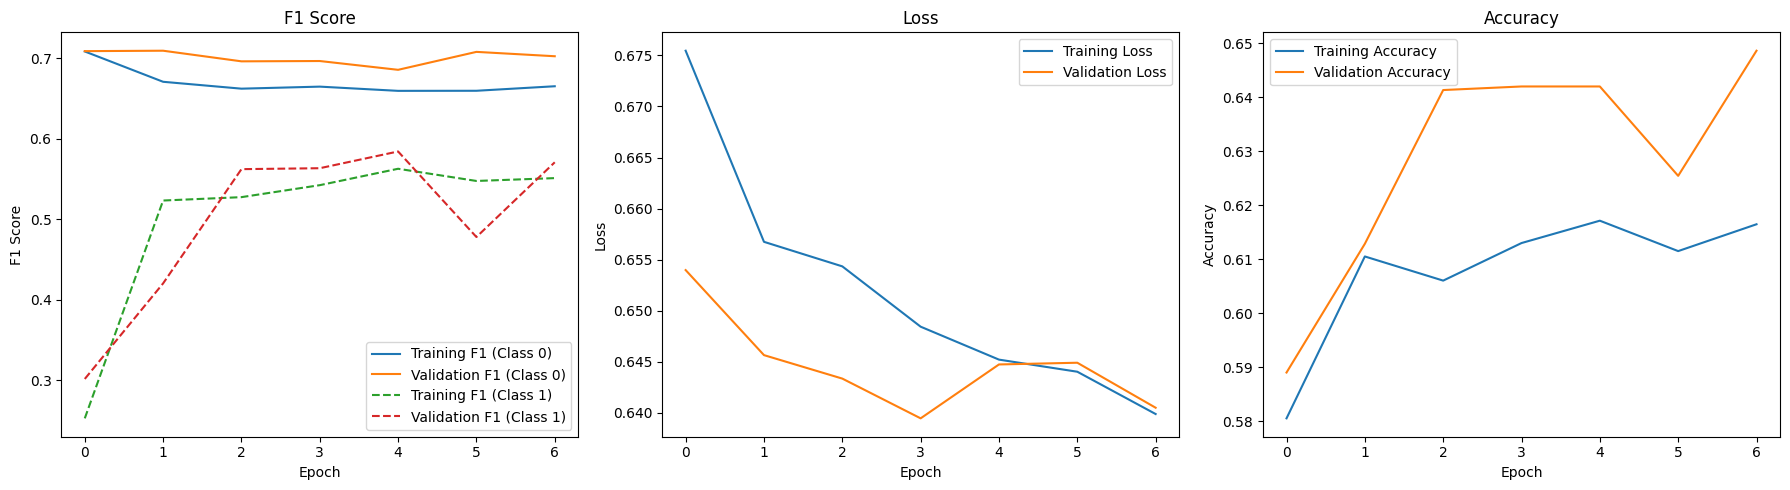

In [ ]:
# Extract training and validation metrics
plotEvaluationMetrics(trained_model.history)

We can see that validation loss and training starting diverging after epoch 4 and training early stopped. Also, our validation and training accuracy graphs suggest our learning rate is high. Let's rebuild our model with different hyper-parameters.

#### 3. Build Revised Model
---

Input (text sequences) → Embedding (100-dimensional word embeddings) → Bidirectional LSTM (64 units) → Dense (2 units, sigmoid) → Output (class probabilities)

---
* Output Layer Activation: Sigmoid, used for binary classification.
* Epochs: 10 epochs
* Loss Function: Binary cross-entropy, suitable for binary classification tasks
* Optimizer: RMSprop
* Learning rate 0.001

**In this model we will use RMS optimizer and 0.001 learning rate. Rest of the architecture will remain same.**

In [ ]:
revised_model_ROC = tf.keras.metrics.AUC()
revised_model_F1 = tf.keras.metrics.F1Score()

# Build the model
revised_model = Sequential()
revised_model.add(Embedding(vocab_size, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
revised_model.add(Bidirectional(LSTM(64)))
revised_model.add(Dense(2, activation="sigmoid"))

# Compile the model
#model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
revised_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', revised_model_ROC, revised_model_F1])

revised_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 140, 100)          1985300   
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2070038 (7.90 MB)
Trainable params: 84738 (331.01 KB)
Non-trainable params: 1985300 (7.57 MB)
_________________________________________________________________


#### 4. Train Model


In [ ]:
# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)

# Train the model with early stopping
revised_trained_model = revised_model.fit(X_train, y_train, epochs=10,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

Epoch 1/10
189/189 [==============================] - 9s 26ms/step - loss: 0.6678 - accuracy: 0.5891 - auc_7: 0.6269 - f1_score: 0.5197 - val_loss: 0.6468 - val_accuracy: 0.6631 - val_auc_7: 0.6815 - val_f1_score: 0.6596
Epoch 2/10
189/189 [==============================] - 5s 25ms/step - loss: 0.6480 - accuracy: 0.6251 - auc_7: 0.6710 - f1_score: 0.6034 - val_loss: 0.6431 - val_accuracy: 0.6175 - val_auc_7: 0.6823 - val_f1_score: 0.4929
Epoch 3/10
189/189 [==============================] - 3s 14ms/step - loss: 0.6363 - accuracy: 0.6491 - auc_7: 0.6912 - f1_score: 0.6296 - val_loss: 0.6152 - val_accuracy: 0.6764 - val_auc_7: 0.7266 - val_f1_score: 0.6612
Epoch 4/10
189/189 [==============================] - 3s 14ms/step - loss: 0.6223 - accuracy: 0.6585 - auc_7: 0.7124 - f1_score: 0.6396 - val_loss: 0.6126 - val_accuracy: 0.6764 - val_auc_7: 0.7260 - val_f1_score: 0.6261
Epoch 5/10
189/189 [==============================] - 3s 19ms/step - loss: 0.6162 - accuracy: 0.6636 - auc_7: 0.7195

{'loss': [0.6677992343902588, 0.6480154991149902, 0.6362870335578918, 0.6223247647285461, 0.6161601543426514, 0.6043033003807068, 0.5937390327453613, 0.5809259414672852, 0.5728551149368286, 0.5637615323066711], 'accuracy': [0.5891408920288086, 0.6250620484352112, 0.6490647196769714, 0.6585002541542053, 0.6636318564414978, 0.6828339695930481, 0.6873034238815308, 0.7036914229393005, 0.7031948566436768, 0.7166032195091248], 'auc_7': [0.6268883943557739, 0.6710181832313538, 0.6912102699279785, 0.7124412059783936, 0.7194747924804688, 0.7366607785224915, 0.7488073110580444, 0.7632172703742981, 0.7720212936401367, 0.7806293964385986], 'f1_score': [array([0.70232666, 0.33707267], dtype=float32), array([0.6960956 , 0.51069343], dtype=float32), array([0.7145166, 0.5446735], dtype=float32), array([0.72215486, 0.55701095], dtype=float32), array([0.72316074, 0.5714889 ], dtype=float32), array([0.739886  , 0.59372354], dtype=float32), array([0.7437254, 0.5990235], dtype=float32), array([0.75856483, 

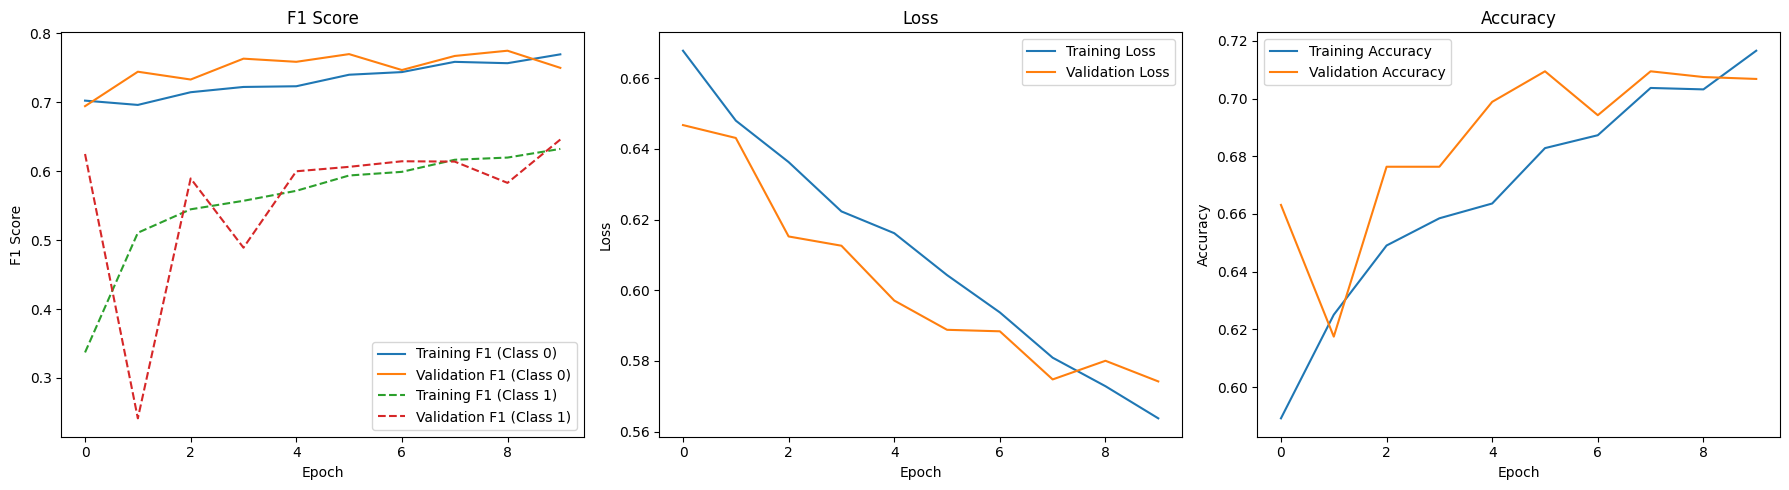

In [ ]:
# Extract training and validation metrics
plotEvaluationMetrics(revised_trained_model.history)

We can see that this model performed well with high F1 scores for both 0 and 1 labels as well as smooth loss graph suggesting appropriate learning rate. We got high accuracy for validation data as well in this as can be seen in the graph.

# Kaggle score for our model
Let's build the submission file for kaggle now using our revised model.

In [ ]:
# Evaluate on the test set
y_pred = revised_model.predict(padded_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes


102/102 [==============================] - 1s 11ms/step


array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
results_df = pd.DataFrame()
results_df['id'] = test_df['id']
results_df['target'] = y_pred_classes
print(results_df.head())
results_df.info()

   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [ ]:
results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/MSDS_deep_learning/submission_week4.csv', index=False)

In [ ]:
! kaggle competitions submit -c nlp-getting-started -f /content/drive/MyDrive/Colab\ Notebooks/MSDS_deep_learning/submission_week4.csv -m "MSDS"

100% 22.2k/22.2k [00:00<00:00, 25.3kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

We received .68556 score on kaggle.


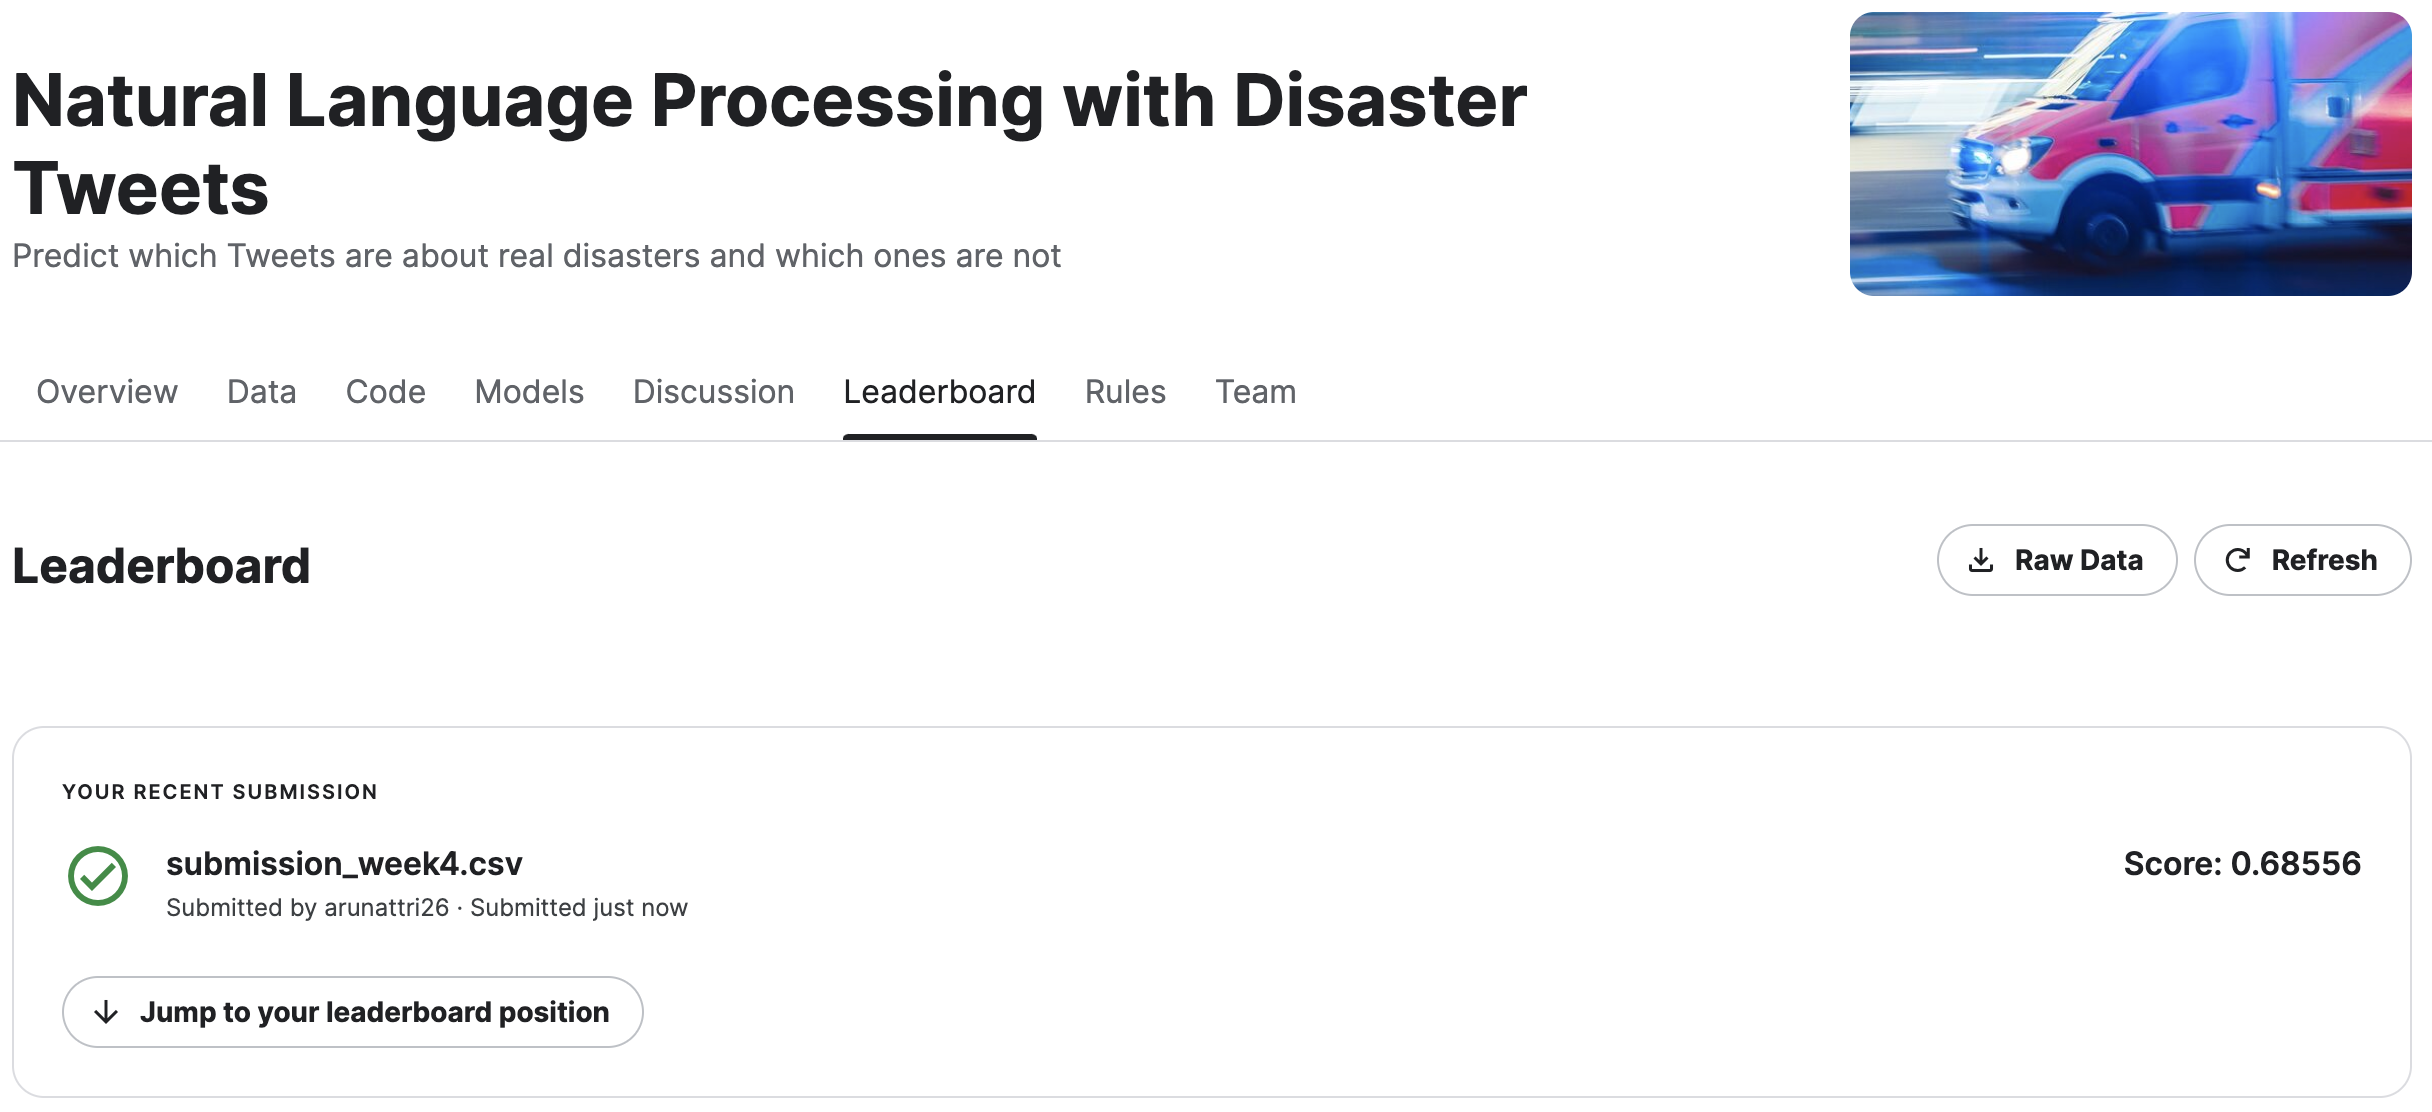

# Conclusion
We can conclude that our revised model performed the best with RMSprop optimization and 0.001 learning without regularization techniques.

Bidirectional LSTM performed well to generalize on the data.
We could try with different optimizers and LSTM layer to see if that performs better.